## **Text Models & Neural Networks**

**Part A: Build a classification model using text data**

For Part A, you will be solving a text classification task. The training data is stored in the Homework 4 Data folder. The data consists of headlines that have been labeled for whether they are clickbait.

1. Import the data. The headlines will become your vectorized X matrix, and the labels indicate a binary classification (clickbait or not).
2. Convert the headline data into an X feature matrix using a simple bag of words approach.
3. Run logistic regression to predict clickbait headlines. Remember to train_test_split your data and use GridSearchCV to find the best value of C. You should evaluate your data with F1 scoring.
4. Run 2 more logistic regression models by changing the vectorization approach (e.g. using n-grams, stop_words, and other techniques we discussed). In both cases, keep your logistic regression step the same. Only change how you're generating the X matrix from the text data.
5. Which of your 3 models performed best? What are the most significant coefficients in each, and how do they compare?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
data = pd.read_csv('text_training_data.csv')

In [3]:
def visualize_coefficients(coefficients, feature_names, n_top_features=25):
  coefficients = coefficients.squeeze()
  if coefficients.ndim > 1:
    raise ValueError("cofficients must be 1d array or column vector, got"
    " shape {}".format(coefficients.shape))
  coef = coefficients.ravel()
  positive_coefficients = np.argsort(coef)[-n_top_features:]
  negative_coefficients = np.argsort(coef)[:n_top_features]
  interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

  plt.figure(figsize=(15, 5))
  colors = ['#ff2020' if c < 0 else '#0000aa'
            for c in coef[interesting_coefficients]]
  plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
          color=colors)
  feature_names = np.array(feature_names)
  plt.subplots_adjust(bottom=0.3)
  plt.xticks(np.arange(1, 1 + 2 * n_top_features),
             feature_names[interesting_coefficients], rotation=60, ha="right")
  plt.ylabel("Coefficient magnitude")
  plt.xlabel("Feature")

### **Conclusion**
1. **3 best-performed models are:** 'Simple bag of words approach', 'n-grams approach', and 'TfidVectorizer approach'.


2. **Most significant coefficients are:**
* **Simple bag of words approach:** Coefficient of '2015' (positive), Coefficient of 'pitch' (negative)
* **n-grams approach:** Coefficient of 'you' (positive), coefficient of 'says' (negative)
* **n_gram approach, specify 'min_df' and 'max_features':** Coefficient of 'you' (positive), coefficient of 'wins' (negative)
* **n_gram & stop_words approach:** Coefficient of 'know' (positive), coefficient of 'dies' (negative)
* **TfidVectorizer approach:** Coefficient of 'you' (positive), coefficient of 'pitch' (negative)
* **TfidVectorizer & stop_words approach:** Coefficient of 'people' (positive), coefficient of 'dies' (negative)

Across all models, the word 'you' shows the most positive coefficients on average, while 'die' and 'pitch' show the most negative coefficients on average.

3. **Why the significant coefficients are different in different models:**
 * **In Bag of words approach:** Since it count the frequency of each word and doesn't consider the order or context, words like '2015' here might be significant.
 * **In n-grams approach:** Since it can seperate words into features like "I like", which is able to consider the context and the correlation between different sigle words, it could make some combined words more significant.
 * **In TfidVectorizer approach:** This method adjusts the weight of a word's importance by considering how frequently a word appears within a document compared to all documents. Therefore, common words might be downweighted.

### **1. Simple bag of words approach**

In [4]:
data['label_binary'] = data['label'].map({'clickbait': 1, 'not clickbait': 0})
count =  CountVectorizer()
X = count.fit_transform(data['headline'])
y = data['label_binary']

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(18734, 20332)
(18734,)
(6245, 20332)
(6245,)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")

Best mean cross-validation score: 0.969
Best parameters: {'C': 10}
f1 score: 0.9668807029401825


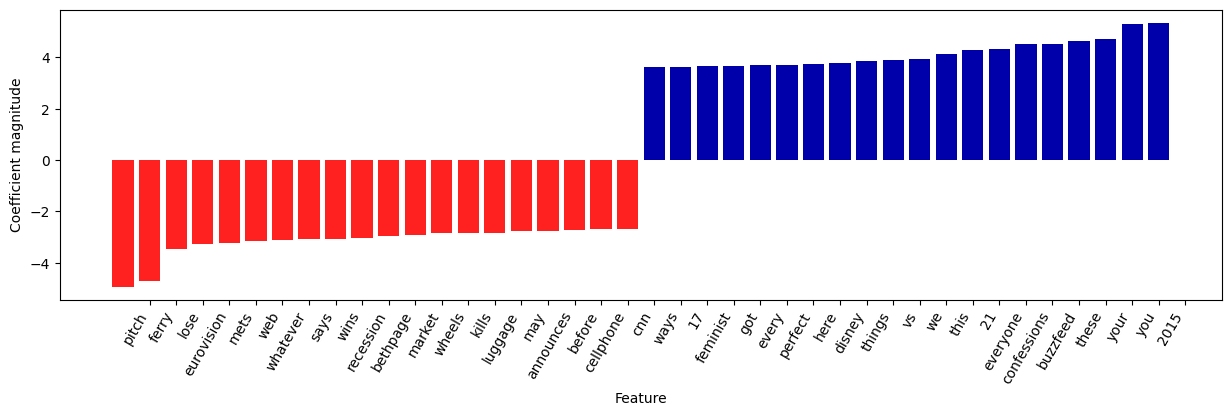

In [7]:
coefs = grid_search.best_estimator_.coef_
feature_names = count.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of '2015' (positive), Coefficient of 'pitch' (negative)

### **2. n-grams approach**

In [8]:
cv = CountVectorizer(ngram_range=(1,2))
X = cv.fit_transform(data['headline'])
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)
print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")


Best mean cross-validation score: 0.968
Best parameters: {'C': 100}
f1 score: 0.9652027027027027


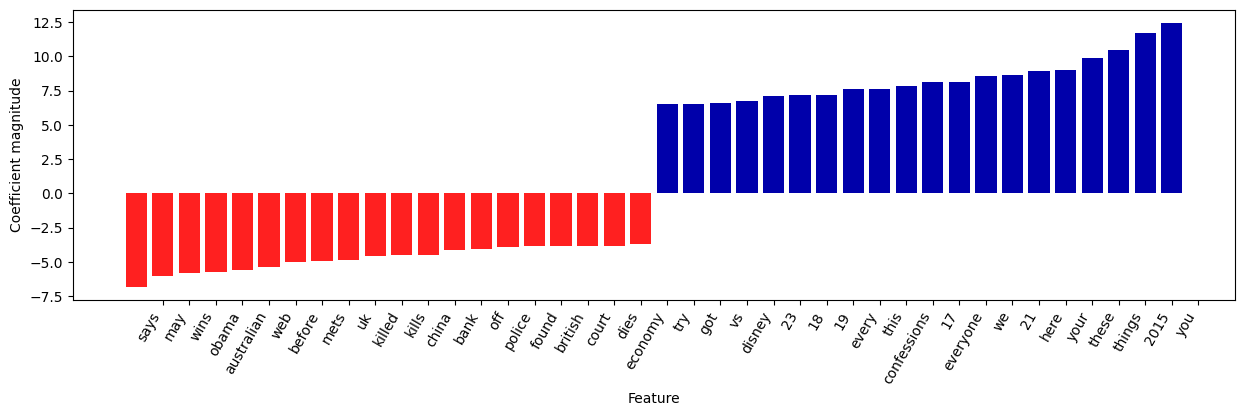

In [9]:
coefs = grid_search.best_estimator_.coef_
feature_names = cv.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of 'you' (positive), coefficient of 'says' (negative)

### **3. n_gram approach, specify 'min_df' and 'max_features'**

In [10]:
cv = CountVectorizer(ngram_range=(1, 2), min_df=2, max_features=5000)
X = cv.fit_transform(data['headline'])
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")

Best mean cross-validation score: 0.967
Best parameters: {'C': 1}
f1 score: 0.9645582499576055


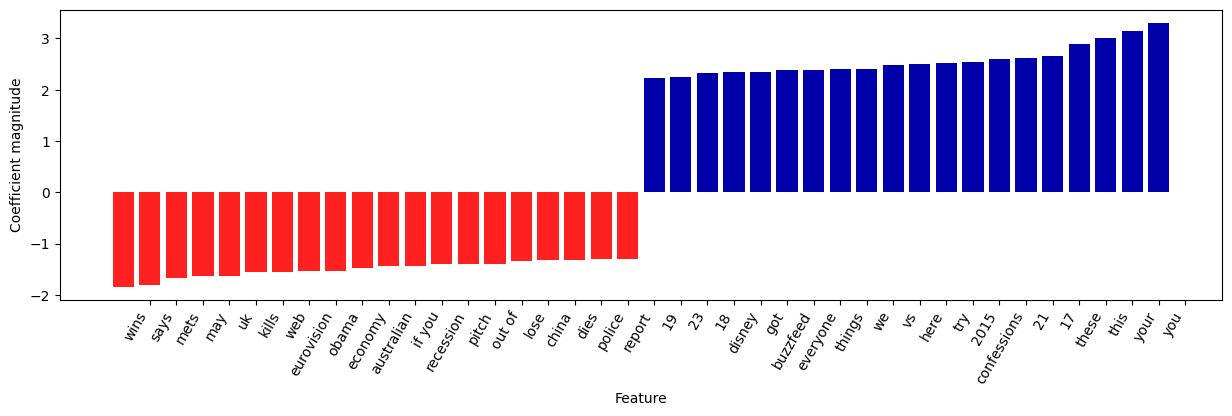

In [11]:
coefs = grid_search.best_estimator_.coef_
feature_names = cv.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of 'you' (positive), coefficient of 'wins' (negative)

### **4. n_gram & stop_words approach**

In [12]:
cv = CountVectorizer(stop_words='english', ngram_range=(1, 2), min_df=2, max_features=5000)
X = cv.fit_transform(data['headline'])
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")

Best mean cross-validation score: 0.945
Best parameters: {'C': 1}
f1 score: 0.9399522347321734


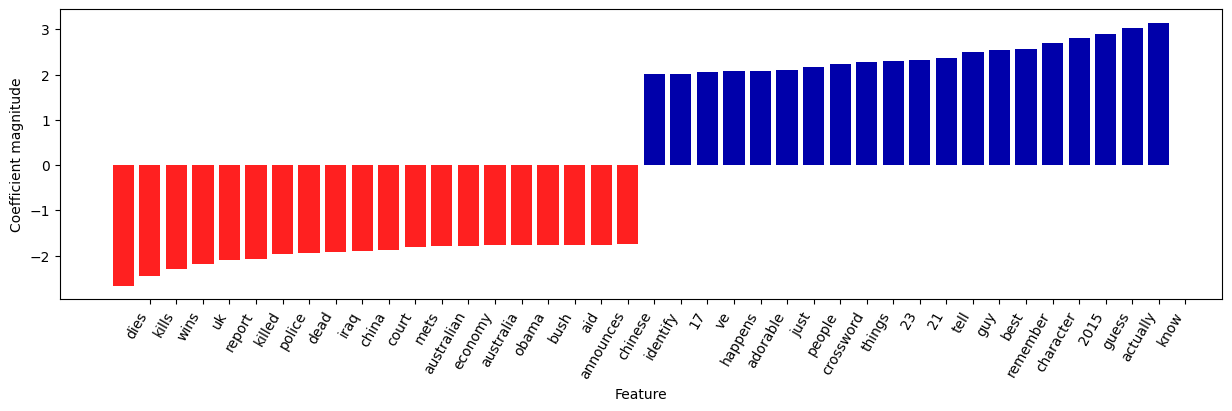

In [13]:
coefs = grid_search.best_estimator_.coef_
feature_names = cv.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of 'know' (positive), coefficient of 'dies' (negative)

### **5. TfidVectorizer approach**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(data['headline'])
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")


Best mean cross-validation score: 0.969
Best parameters: {'C': 100}
f1 score: 0.9689084150050693


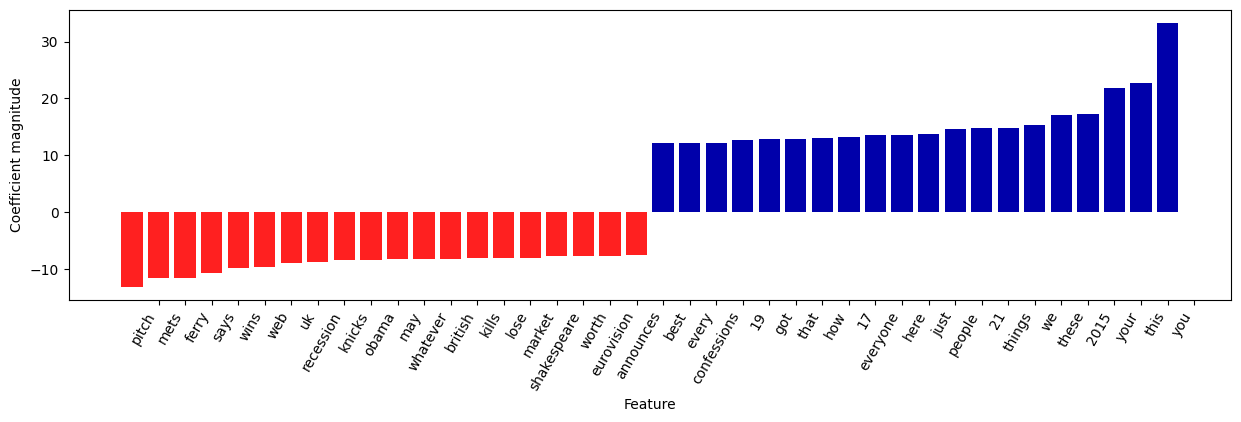

In [15]:
coefs = grid_search.best_estimator_.coef_
feature_names = tfidf.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of 'you' (positive), coefficient of 'pitch' (negative)

### **6. TfidVectorizer & stop_words approach**

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(data['headline'])
y = data['label_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100, 1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

y_pred = grid_search.predict(X_test)
print(f"f1 score: {f1_score(y_test, y_pred)}")

Best mean cross-validation score: 0.950
Best parameters: {'C': 10}
f1 score: 0.9478899709550658


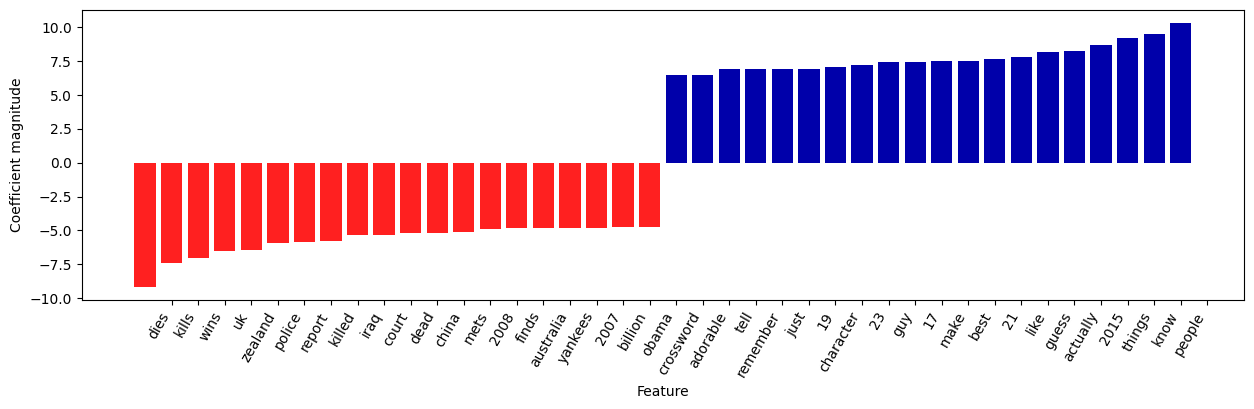

In [17]:
coefs = grid_search.best_estimator_.coef_
feature_names = tfidf.get_feature_names_out()
visualize_coefficients(coefs, feature_names, n_top_features=20)

**Most significant coefficient:** Coefficient of 'people' (positive), coefficient of 'dies' (negative)



---


**Part B: Build a Predictive Neural Network Using Keras**

In Part B, you will run a multilayer perceptron on the iris dataset to predict flower type.

1. Load the data. Data can be imported directly using pd.read_csv() and the link http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv.
2. Using the Sequential interface in Keras, build a model with 2 hidden layers with 16 neurons in each. Compile and fit the model. Assess its performance using accuracy on data that has been train_test_split.
3. Run 2 additional models using different numbers of hidden layers and/or hidden neurons.
4. How does the performance compare between your 3 models?

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('http://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv')
data.head()

,rownames,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,1,5.1,3.5,1.4,0.2,setosa
1,2,4.9,3.0,1.4,0.2,setosa
2,3,4.7,3.2,1.3,0.2,setosa
3,4,4.6,3.1,1.5,0.2,setosa
4,5,5.0,3.6,1.4,0.2,setosa


In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

data['Species_int'] = data['Species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
X = data.loc[:, ['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
y = data['Species_int']
y = to_categorical(y, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### **1. Build a model with 2 hidden layers with 16 neurons in each. Compile and fit the model. Assess its performance using accuracy on data that has been train_test_split.**

* **Accuracy (f1 score) on the test set:** 0.263
* As we have observed, accuracy score is retatively low here

In [3]:
model = Sequential()
# Note: input_dim is the number of features you are using as input to the model.
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

sgd = SGD(learning_rate=.01)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Score:{:.3f}".format(score[0]))
print("Test Accuracy:{:.3f}".format(score[1]))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step - accuracy: 0.3482 - loss: 1.8270
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4018 - loss: 1.5700
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6339 - loss: 1.3761
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6607 - loss: 1.2575
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6607 - loss: 1.1843
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6607 - loss: 1.1485
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6607 - loss: 1.1312
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6607 - loss: 1.1173
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6607 - loss: 1.1054
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6607 - loss: 1.0950
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6607 - loss: 1.0856
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6607 - loss: 1.0771
Epoch 13/20

### **2. 3 hidden layers and 16 neurons for each layer.**

* **Accuracy (f1 score) on the test set:** 0.868
* As we have observed, accuracy score has increased compared to the first model

In [5]:
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=4))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))

sgd = SGD(learning_rate=.01)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Score:{:.3f}".format(score[0]))
print("Test Accuracy:{:.3f}".format(score[1]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3393 - loss: 1.4402
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3393 - loss: 1.2308
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5982 - loss: 1.0943
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.6518 - loss: 1.0081
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6518 - loss: 0.9574
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6518 - loss: 0.9210
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.6518 - loss: 0.8946
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.6518 - loss: 0.8728
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6518 - loss: 0.8538
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.6518 - loss: 0.8366
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.6518 - loss: 0.8214
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6518 - loss: 

### **3. 2 hidden layer with 32 neurons for the hidden layer.**

* **Accuracy (f1 score) on the test set:** *0.711*
* As we have observed, accuracy score has increased compared to the first model

In [10]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=4))
model.add(Dense(32, activation='relu', input_dim=4))
model.add(Dense(3, activation='softmax'))

sgd = SGD(learning_rate=.01)
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=128)
score = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Score:{:.3f}".format(score[0]))
print("Test Accuracy:{:.3f}".format(score[1]))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3125 - loss: 1.1894
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.3839 - loss: 1.1432
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5446 - loss: 1.1069
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6429 - loss: 1.0775
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.6518 - loss: 1.0531
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6429 - loss: 1.0328
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6339 - loss: 1.0158
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6250 - loss: 1.0012
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6250 - loss: 0.9889
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6250 - loss: 0.9789
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6339 - loss: 0.9702
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6429 - loss: 0.9

### **4. How does the performance compare between your 3 models?**

* **Conclusion:**
 * 2 hidden layers with 16 neurons in each:
   * Accuracy on the test set: 0.263
 * 3 hidden layers and 16 neurons for each layer:
   * Accuracy on the test set: 0.868
 * 2 hidden layers with 32 neurons for the hidden layer:
   * Accuracy on the test set: 0.711

We can see the best performed model is "3 hidden layers and 16 neurons for each layer", whose accuracy score is 0.868.
* With the same neuron number, in this case, if the hidden layer number is higher, the accuracy score will be higher.
* With the same hidden layer number, in this case, if the neuron number is higher, the accuracy score will be higher.
